In [1]:
%cd "C:/app"

C:\app


In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

**Prepare data**

In [4]:
# load data
from sklearn.preprocessing import scale


data = pd.read_csv("./data/trees/features_targets.csv", index_col="Timestamp", parse_dates=["Timestamp"])

excluded_cols = ['Open',
 'High',
 'Low',
 'Close',
 'Symbol']

all_cols = [c for c in data.columns if c not in excluded_cols ]
data = data[all_cols]

data.loc[:, data.columns] = scale(data)

features_cols = data.columns[data.columns.str.contains("TARGET") == False]
features = data[features_cols]
features.describe()

target_col = "TARGET_LOGRET_5"
targets = data[[target_col]]
targets.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 13906 entries, 2018-01-26 15:00:00 to 2019-12-31 15:30:00
Data columns (total 1 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   TARGET_LOGRET_5  13906 non-null  float64
dtypes: float64(1)
memory usage: 217.3 KB


In [5]:
# select two features for the rest
X = pd.get_dummies(features)
y = targets
y_binary = (y > 0.1).astype(int)

<Axes: ylabel='Density'>

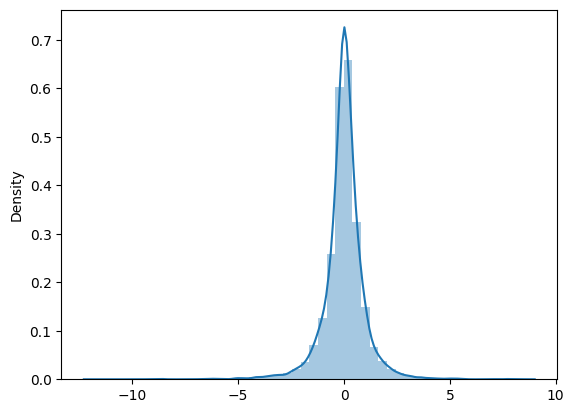

In [6]:
# Explore data
sns.distplot(y)

**Random Forests**

In [7]:
# Cross-validation
from sklearn.model_selection import TimeSeriesSplit

# Cross-validation parameters
train_period_length = 500
test_period_length = 50

cv = TimeSeriesSplit(
            max_train_size=train_period_length, 
            test_size=test_period_length
        );

In [8]:
# classifier
from sklearn.ensemble import RandomForestClassifier

rf_clf = RandomForestClassifier(n_estimators=100,  # number of trees 
                                criterion='entropy', 
                                max_depth=None, 
                                n_jobs=-1,
                                verbose=1)
rf_clf

RandomForestClassifier(criterion='entropy', n_jobs=-1, verbose=1)

In [9]:
# Cross-Validation with default settings
metric = "accuracy"
from sklearn.model_selection import GridSearchCV, cross_val_score
cv_score = cross_val_score(estimator=rf_clf,
                           X=X,
                           y=y_binary,
                           scoring=metric,
                           cv=cv,
                           n_jobs=-1,
                           verbose=1)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   14.6s finished


In [10]:
np.mean(cv_score)

0.56

**Parameter Tuning**

In [11]:
param_grid = {'n_estimators': [50, 100, 250],
              'max_depth': [5, 15, None],
              'min_samples_leaf': [5, 25, 100]}

# Instantiate GridSearchCV
gridsearch_clf = GridSearchCV(estimator=rf_clf,
                              param_grid=param_grid,
                              scoring=metric,
                              n_jobs=-1,
                              cv=cv,
                              refit=True,
                              return_train_score=True,
                              verbose=1)
# Fit Classifier
gridsearch_clf.fit(X=X, y=y_binary)

Fitting 5 folds for each of 27 candidates, totalling 135 fits


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.9s finished


GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=500, n_splits=5, test_size=50),
             estimator=RandomForestClassifier(criterion='entropy', n_jobs=-1,
                                              verbose=1),
             n_jobs=-1,
             param_grid={'max_depth': [5, 15, None],
                         'min_samples_leaf': [5, 25, 100],
                         'n_estimators': [50, 100, 250]},
             return_train_score=True, scoring='accuracy', verbose=1)

In [12]:
gridsearch_clf.best_score_

0.592

**Feature Importance**

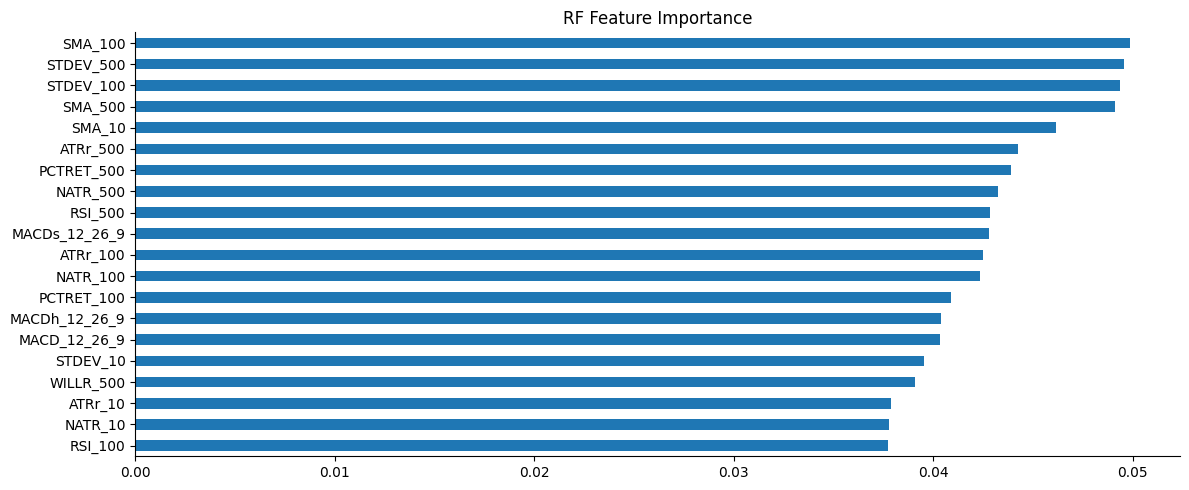

In [13]:
fig, ax = plt.subplots(figsize=(12,5))
# feature imoprtance for forest tree: for every tree, which feature appears most to the top of trees => important
(pd.Series(gridsearch_clf.best_estimator_.feature_importances_, 
           index=X.columns)
 .sort_values(ascending=False)
 .iloc[:20]
 .sort_values()
 .plot.barh(ax=ax, title='RF Feature Importance'))
sns.despine()
fig.tight_layout();